# Stock price forecasting

The dataset contains stock market data of Microsoft Corporation(MSFT) and it can be downloaded from Yahoo Finance.

The data shows the 10 year historical stock prices of Microsoft Corporation(MSFT) from 2011-01-01 till 2021-05-31. The goal is to train an ARIMA model with optimal parameters that will forecast the closing price of the stocks on the test data.

In [1]:
import os
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
COMPANY_NAME = 'Microsoft Corporation'
STOCK_TICKER = 'MSFT'
START_DATE = '2011-01-01'
END_DATE = '2021-05-31'

### Import Libraries

**Load the stock closing prices data**

In [3]:
ticker_df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
ticker_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,28.049999,28.180000,27.920000,27.980000,22.143803,53443800
2011-01-04,27.940001,28.170000,27.850000,28.090000,22.230862,54405600
2011-01-05,27.900000,28.010000,27.770000,28.000000,22.159628,58998700
2011-01-06,28.040001,28.850000,27.860001,28.820000,22.808588,88026300
2011-01-07,28.639999,28.740000,28.250000,28.600000,22.634483,73762000
...,...,...,...,...,...,...
2021-05-24,247.789993,251.160004,247.509995,250.779999,250.779999,21411500
2021-05-25,251.770004,252.750000,250.820007,251.720001,251.720001,17704300
2021-05-26,251.429993,252.940002,250.750000,251.490005,251.490005,17771600


**Save the file for later use in dashboard**

In [4]:
ticker_df.to_csv('Export Files/msft_closing_price.csv')

**Plot closing price of the stock from the dataframe**

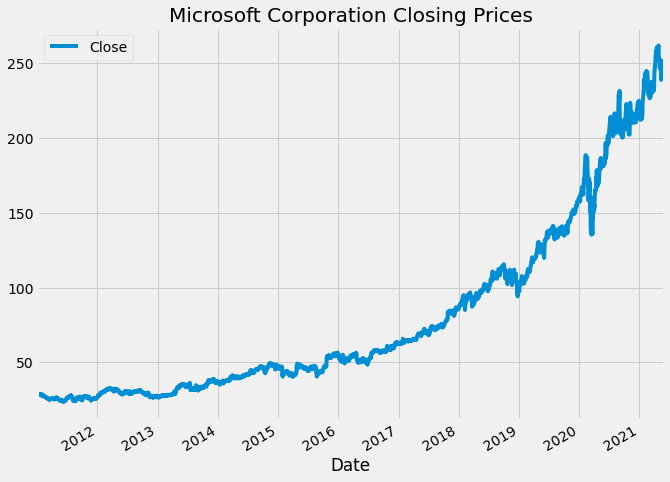

In [5]:
ticker_df['Close'].plot(
    title=COMPANY_NAME+' Closing Prices', 
    legend='Close', 
    figsize=(10, 8))
plt.margins(x=0)

From the above graph, we observe an upwards trend. As we know, a time series with an upward or downward trend is non-stationary. So, First, we need to check if a series is stationary or not because time series analysis only works with stationary data. 

We can use one of most popular statistical test called ADF(Augmented Dickey-Fuller)Test. It can be used to test whether a given time series is stationary or not by determing the presence of unit root in the series.
The null and alternate hypothesis of this test is:

- Null Hypothesis: The series has a unit root (value of a =1)

- Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

**Define a `test_stationarity` function to check the stationarity of the time series dataset**

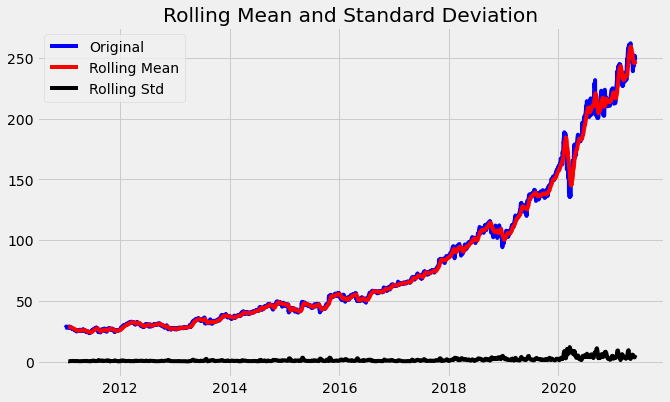

Results of dickey fuller test
Test Statistics                   4.478140
p-value                           1.000000
No. of lags used                 26.000000
Number of observations used    2592.000000
critical value (1%)              -3.432875
critical value (5%)              -2.862656
critical value (10%)             -2.567364
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(ticker_df['Close'])

**Observations**

From the above test results, we can observe the following:

- p-value is greater than the significance value 0.05. So, we cannot reject the null hypothesis.
- test statistics is also greater than the critical value.

Therefore, the time series data is non-stationary.

**Decomposition**

A time series consists of three systematic components(a time series that have consistency and can be described and modeled) including level, trend, seasonality, and one non-systematic component(that cannot be directly modeled) called noise. To analyze the time series data, we need to separate the trend, seasonality and noise.

These components are defined as follows:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series. 

<Figure size 720x432 with 0 Axes>

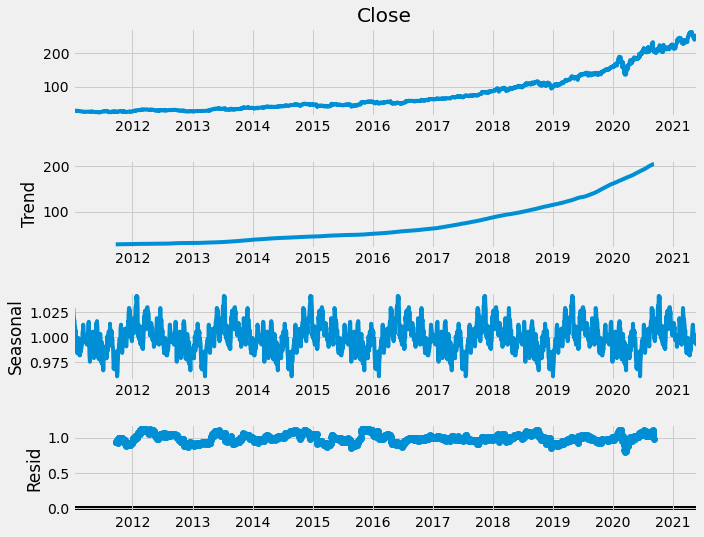

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ticker_df['Close'], model='multiplicative', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 8)

**To reduce the magnitude of the values and the rising trend in the series, we use log of the series.**

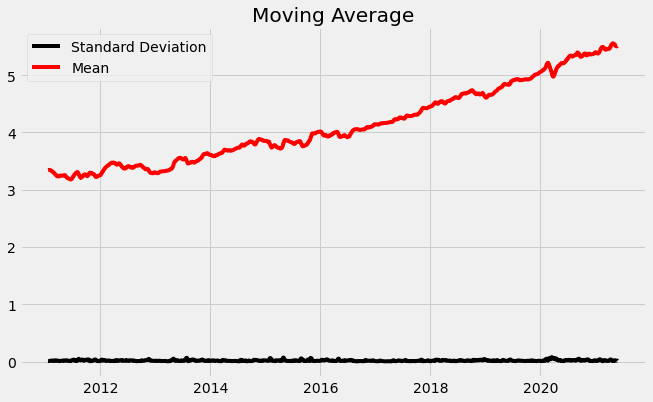

In [8]:
ticker_log_df = np.log(ticker_df['Close'])
moving_avg = ticker_log_df.rolling(12).mean()
std_dev = ticker_log_df.rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

<Figure size 720x432 with 0 Axes>

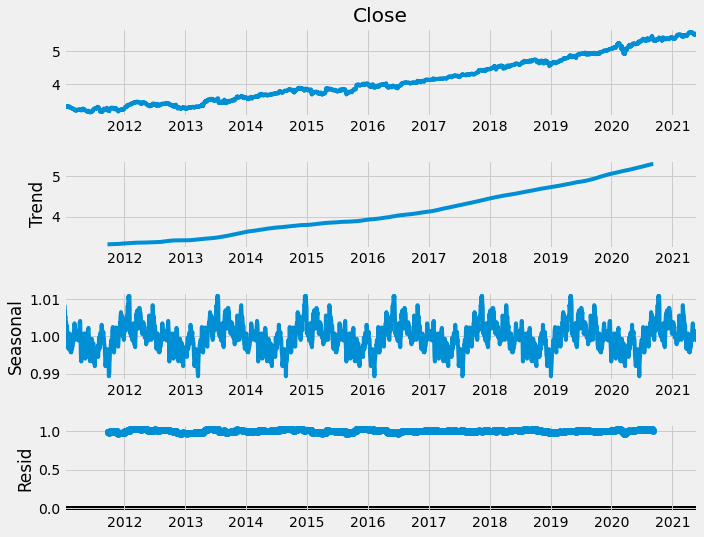

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ticker_log_df, model='multiplicative', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 8)

### Forecasting the Close Price using an ARIMA Model

Using the Close Price, estimate an ARIMA model. First, we need to choose the parameters(p,d,q) of the model. There are so many ways to find the parameters. We use the following:

- ACF and PACF

- Auto ARIMA

**Split the data set into a 70% for training and 30% for testing**

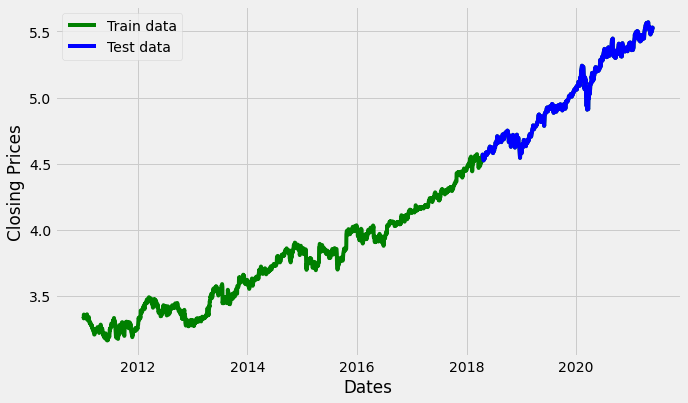

In [10]:
split_data = int(len(ticker_log_df)*0.7)

train_data = ticker_log_df[0:split_data]
test_data = ticker_log_df[split_data:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ticker_log_df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

**Define a `plot_predictions` function which is used to plot the predicted prices**

In [11]:
def plot_predictions(predictions):
    pred_series = pd.Series(predictions[:len(test_data)], index=test_data.index)
    plt.figure(figsize=(15,10), dpi=50)
    plt.plot(train_data, label='training')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(pred_series, color = 'orange',label='Predicted Stock Price')
    plt.title(COMPANY_NAME+' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

**Define a `performance_report` function which is used to calculate the mean squared error and root mean squared error**

In [12]:
def performance_report(predictions):
    pred = predictions[:len(test_data)]
    # report performance
    mse = mean_squared_error(test_data, pred)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(test_data, pred)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(test_data, pred))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(pred - test_data)/np.abs(test_data))
    print('MAPE: '+str(mape))

###  1. Autocorrelation Function and Partial Autocorrelation Function Analysis

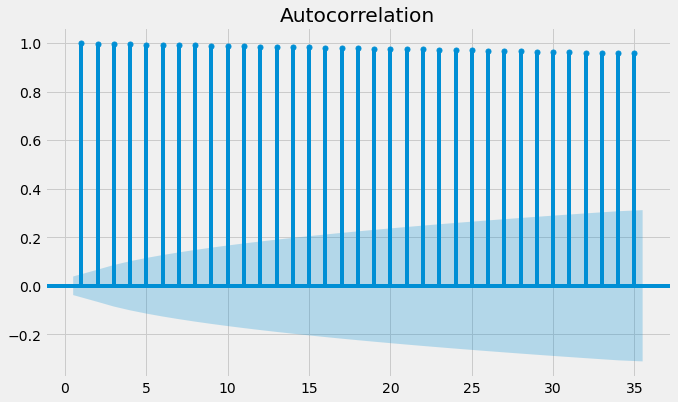

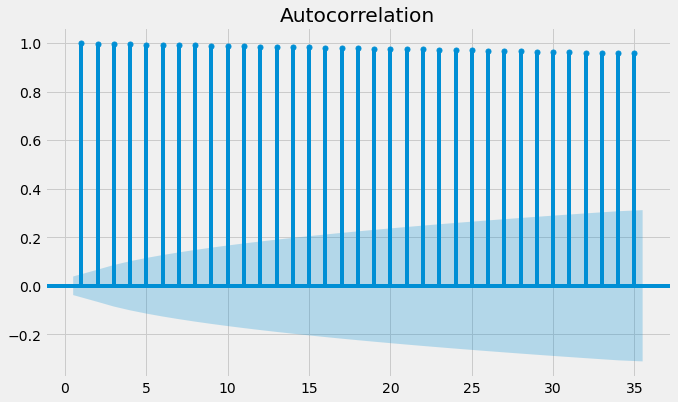

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation of the Close Prices
plot_acf(ticker_log_df, zero=False, lags=35)

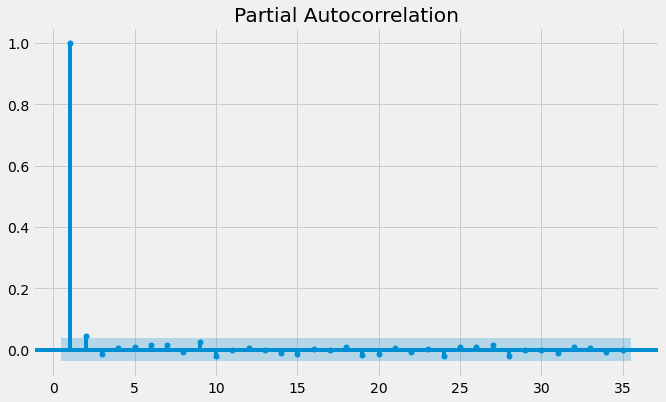

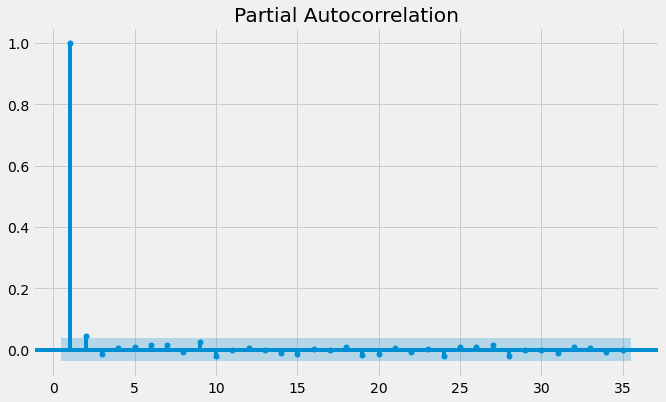

In [14]:
# Plot the partial autocorrelation 
plot_pacf(ticker_log_df, zero=False, lags=35)

### Build Arima model 

Using the Close Price, estimate an ARIMA model. Set P=1, D=1, and Q=0 in the model (e.g., ARIMA(df, order=(1,1,1)) P= parameter of Auto-Regressive Lag 1, D= parameter of Differences 1 (this is usually =1), Q= parameter of Moving Average Lag of 1

In [69]:
arima_model = ARIMA(train_data, order=(1,1,0))
arima_fit = arima_model.fit(disp=0)
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1832
Model:                 ARIMA(1, 1, 0)   Log Likelihood                5176.040
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 10 Jun 2021   AIC                         -10346.079
Time:                        14:32:10   BIC                         -10329.540
Sample:                             1   HQIC                        -10339.980
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      2.022      0.043    2.03e-05       0.001
ar.L1.D.Close    -0.0233      0.023     -0.999      0.318      -0.069       0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -42.8414           +0.0000j           42.8414            0.5000
-----------------------------------------------------------------------------
"""

**Predict the closing prices using test data**

In [70]:
predictions1,_,_ = arima_fit.forecast(len(test_data))

**Plot the actual and predicted prices**

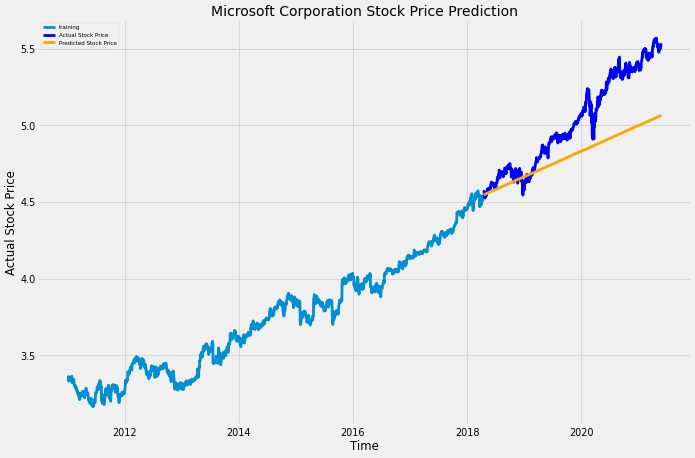

In [71]:
plot_predictions(predictions1)

**Evaluate the model**

In [72]:
performance_report(predictions1)

MSE: 0.07292953276182709
MAE: 0.21917308376780895
RMSE: 0.2700546847618591
MAPE: 0.041932049036681435


Around 4.2% MAPE(Mean Absolute Percentage Error) implies the model is about 95.8.% accurate in predicting the test set observations.

## 2. Auto Arima

The `auto_arima` function automatically obtains the optimal parameters of the model and fits the best ARIMA model to a univariate time series according to either AIC, BIC. The function performs a search over possible model orders within the constraints provided.

In [19]:
autoarima_model = auto_arima(
    train_data, 
    start_p=0, 
    start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=3, max_q=3, # maximum p and q
    m=1,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=True,   # No Seasonality
    start_P=0, 
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
print(autoarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10347.081, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10346.079, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10346.131, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10345.180, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10350.778, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10344.276, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10343.335, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10345.347, Time=0.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10345.221, Time=0.73 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10341.280, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10344.765, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.141 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observati

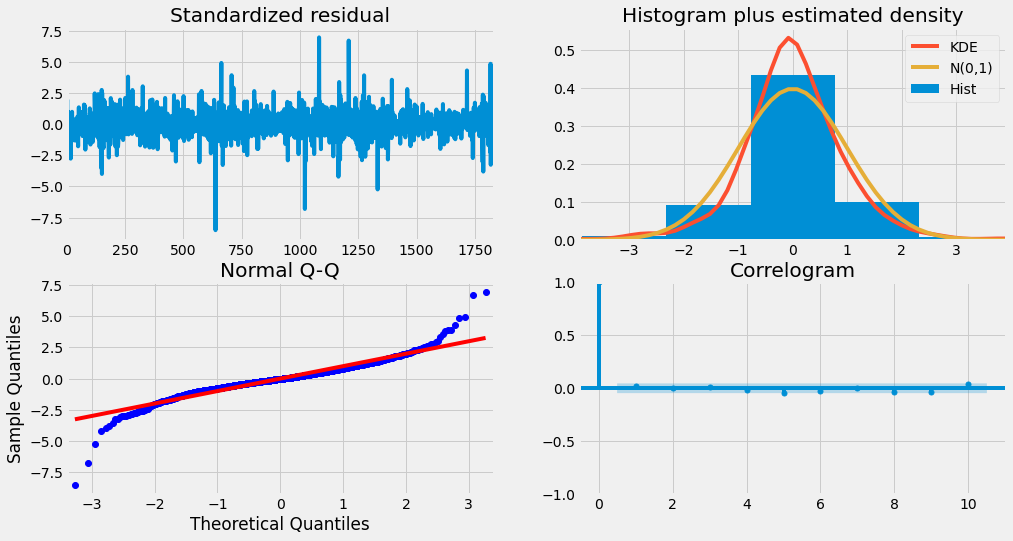

In [20]:
autoarima_model.plot_diagnostics(figsize=(15,8))
plt.show()

From the above plot, we can observe that:

In standardized residual plot, residual error fluctuates around the mean of zero and have uniform variance.

In Histogram density plot, we see the normal distribution with mean zero.

All the dots should fall perfectly in line with the red line. The Normal Q-Q figure suggest that there is some significant deviation that means the distribution is not symmetrical. 

The correlogram(ACF) plot shows that there is some autocorrelation.

**Predict the closing prices using test data**

In [21]:
predictions2 = autoarima_model.predict(len(test_data))

**Plot the actual and predicted prices**

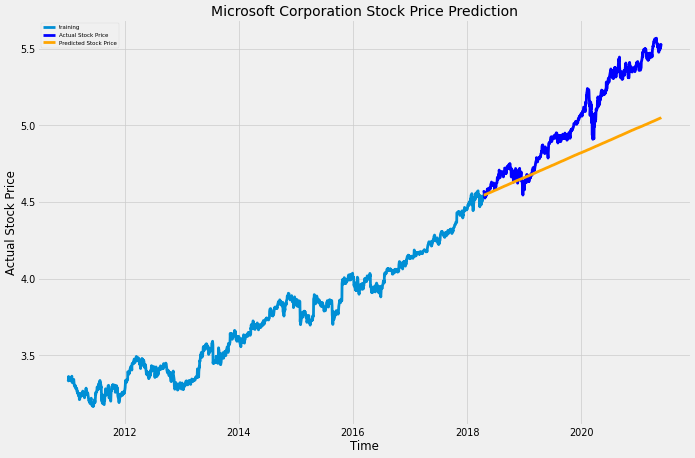

In [22]:
plot_predictions(predictions2)

**Observation:**

The graph above shows the forecasts of the closing price for next d days, where d is the number of datapoints of the test data. As we can see, the predictions form a straight line. This is because we do not retrain the model when new data points are available. That means the model is trained on datapoints `t0, ...tn-1` and is used to predict for d days `tn, tn+1, ...tn+d`. 

**Evaluate the model**

In [73]:
performance_report(predictions2)

MSE: 0.07800026660824241
MAE: 0.22752490140453363
RMSE: 0.2792852781802908
MAPE: 0.04354807378104945


## 3. Rolling Forecast 

**Create `daily_forecast` and `rolling_forecast` functions to predict rolling closing prices**

In [24]:
def daily_forecast(train, num_days):
    autoarima_model = auto_arima(
        train, start_p=0, start_q=0,
        test='adf',       # use adftest to find optimal 'd'
        max_p=2, max_q=2, # maximum p and q
        m=1,              # frequency of series
        d=None,           # let model determine 'd'
        seasonal=False,   # No Seasonality
        start_P=0, 
        D=0, 
        trace=False,
        error_action='ignore',  
        suppress_warnings=True, 
        stepwise=True)
    return autoarima_model.predict(num_days)

In [25]:
def rolling_forecast(step=1):
    train_tmp = train_data
    predictions = []
    for i in range(0, len(test_data), step):
        print('.', end='')
        predictions.extend(daily_forecast(train_tmp, step))
        train_tmp = train_tmp.append(test_data[i:(i+step)])
    return predictions

**Predict the closing prices using test data**

In [26]:
predictions3 = rolling_forecast(5)

..............................................................................................................................................................

**Plot the actual and predicted prices**

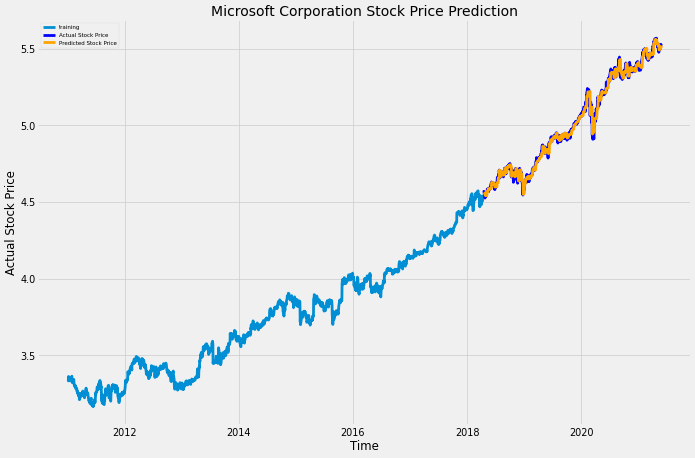

In [27]:
plot_predictions(predictions3)

**Observation:**

The graph above shows the forecast of the closing price for next n days, where n is the number of datapoints of the test data. As we can see, the predictions are very accurate. In this case, we retrain the model when new datapoints are available. That means the model is first trained on datapoints `t0, ...tn-1` and is used to predict `tn`. Once the actual `tn` is available, the model is retrained on data `t0, ...tn` and predicts `tn+1` and so on.

**Evaluate the model**

In [28]:
performance_report(predictions3)

MSE: 0.0007890744278250166
MAE: 0.01995887518606397
RMSE: 0.028090468629501656
MAPE: 0.003981425686565591


- MSE(mean squared error) is used to measure the average of the squares of the errors that means it checks how close forecast values are to actual values. The lower value indicates better fit.

- MAE(mean absolute error) measures the absolute average distance between the real data and the predicted data. As we can see mean absolute error is 0.02, that means the forecast's distance from the actual value is 0.021. Average magnitude of the errors in a set of forecasts, without considering their direction. It measures accuracy for continuous variables.

- RMSE(root mean squared error) measures the square root of the variances. The lower value of MSE and RMSE implies higher accuracy the model. 

- 0.40% of MAPE(Mean Absolute Percentage Error) implies the model is about 99.6% accurate in predicting the test set observations. As we know MAPE < 10% is Excellent, MAPE < 20% is Good. 


## 4. Rolling Forecast with Correlated Assets

### Loading the data

In this project, we have used supervised learning models to predict a stock price. The weekly return of Microsoft stock is the predicted variable. We need to find out what else affects the Microsoft stock price and Incorporate the other features that are useful for stock price prediction into the model.
For independent variable, we are using historical data of Microsoft and correlated assets that are:

Stocks: Apple Inc.(AAPL) and Alphabet Inc.(GOOG)

Currency: USD/JPY(JPY=X) and USD/EUR(EUR=X)

Indices: SPDR S&P 500 ETF Trust(SPY) and Dow Jones Industrial Average(^DJI)

The dataset used for this project is extracted from Yahoo Finance website.

In [29]:
stk_tickers = [STOCK_TICKER, 'AAPL', 'GOOG']
ccy_tickers = ['JPY=X', 'EUR=X']
idx_tickers = ['^GSPC', '^DJI']

stk_data = yf.download(stk_tickers, start=START_DATE, end=END_DATE)
ccy_data = yf.download(ccy_tickers, start=START_DATE, end=END_DATE)
idx_data = yf.download(idx_tickers, start=START_DATE, end=END_DATE)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [30]:
stk_data.head()

Adj Close                             Close                     \
                 AAPL        GOOG       MSFT       AAPL        GOOG   MSFT   
Date                                                                         
2011-01-03  10.121364  301.046600  22.143803  11.770357  301.046600  27.98   
2011-01-04  10.174186  299.935760  22.230862  11.831786  299.935760  28.09   
2011-01-05  10.257413  303.397797  22.159628  11.928571  303.397797  28.00   
2011-01-06  10.249121  305.604523  22.808588  11.918929  305.604523  28.82   
2011-01-07  10.322517  307.069031  22.634483  12.004286  307.069031  28.60   

                 High                           Low                         \
                 AAPL        GOOG   MSFT       AAPL        GOOG       MSFT   
Date                                                                         
2011-01-03  11.795000  301.664276  28.18  11.601429  297.126312  27.920000   
2011-01-04  11.875000  301.958191  28.17  11.719643  298.939514  27.850000   
2011-01-05  11.940714  304.025452  28.01  11.767857  298.904633  27.770000   
2011-01-06  11.973214  308.060303  28.85  11.889286  303.885956  27.860001   
2011-01-07  12.012500  307.970642  28.74  11.853571  303.925812  28.250000   

                 Open                            Volume                     
                 AAPL        GOOG       MSFT       AAPL     GOOG      MSFT  
Date                                                                        
2011-01-03  11.630000  297.126312  28.049999  445138400  4748131  53443800  
2011-01-04  11.872857  301.679230  27.940001  309080800  3662677  54405600  
2011-01-05  11.769643  298.914581  27.900000  255519600  5083583  58998700  
2011-01-06  11.954286  304.199799  28.040001  300428800  4131026  88026300  
2011-01-07  11.928214  306.805023  28.639999  311931200  4218152  73762000

In [31]:
ccy_data.head()

Adj Close               Close                High             \
               EUR=X      JPY=X    EUR=X      JPY=X    EUR=X      JPY=X   
Date                                                                      
2011-01-03   0.74862  81.123001  0.74862  81.123001  0.75455  81.709000   
2011-01-04   0.74868  81.669998  0.74868  81.669998  0.75085  82.267998   
2011-01-05   0.75069  82.038002  0.75069  82.038002  0.76167  83.320000   
2011-01-06   0.76006  83.189003  0.76006  83.189003  0.76724  83.376999   
2011-01-07   0.77042  83.300003  0.77042  83.300003  0.77286  83.657997   

                Low                Open            Volume        
              EUR=X      JPY=X    EUR=X      JPY=X  EUR=X JPY=X  
Date                                                             
2011-01-03  0.74822  81.120003  0.74873  81.139999    0.0   0.0  
2011-01-04  0.74455  81.599998  0.74850  81.671997    0.0   0.0  
2011-01-05  0.75053  81.883003  0.75053  82.010002    0.0   0.0  
2011-01-06  0.75928  82.879997  0.75982  83.160004    0.0   0.0  
2011-01-07  0.76797  82.947998  0.76988  83.269997    0.0   0.0

In [32]:
idx_data.head()

Adj Close                      Close               \
                    ^DJI        ^GSPC          ^DJI        ^GSPC   
Date                                                               
2011-01-03  11670.750000  1271.869995  11670.750000  1271.869995   
2011-01-04  11691.179688  1270.199951  11691.179688  1270.199951   
2011-01-05  11722.889648  1276.560059  11722.889648  1276.560059   
2011-01-06  11697.309570  1273.849976  11697.309570  1273.849976   
2011-01-07  11674.759766  1271.500000  11674.759766  1271.500000   

                    High                        Low               \
                    ^DJI        ^GSPC          ^DJI        ^GSPC   
Date                                                               
2011-01-03  11711.469727  1276.170044  11577.349609  1257.619995   
2011-01-04  11698.219727  1274.119995  11635.740234  1262.660034   
2011-01-05  11742.679688  1277.630005  11652.889648  1265.359985   
2011-01-06  11736.740234  1278.170044  11667.459961  1270.430054   
2011-01-07  11726.940430  1276.829956  11599.679688  1261.699951   

                    Open                  Volume              
                    ^DJI        ^GSPC       ^DJI       ^GSPC  
Date                                                          
2011-01-03  11577.429688  1257.619995  203420000  4286670000  
2011-01-04  11670.900391  1272.949951  178630000  4796420000  
2011-01-05  11688.610352  1268.780029  169990000  4764920000  
2011-01-06  11716.929688  1276.290039  193080000  4844100000  
2011-01-07  11696.860352  1274.410034  188720000  4963110000

Define X and Y features.

For dependent variable(Y), the predicted variable is the weekly return of Microsoft stock. The number of trading days in a week is 5 and we compute the return using 5 trading days.

For independent variable(X), we use the correlated assets and the historical return of Microsoft stock at different time period.

In [33]:
return_period = 5

In [34]:
X1 = np.log(stk_data.loc[:, ('Close', ('AAPL', 'GOOG'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data['Close']).diff(return_period)
X3 = np.log(idx_data['Close']).diff(return_period)
X4 = pd.concat([np.log(stk_data.loc[:, ('Close', 'MSFT')]).diff(r) for r in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_Lag', 'MSFT_3Lag', 'MSFT_6Lag', 'MSFT_12Lag']


X = pd.concat([X1, X2, X3, X4], axis=1)
Y = np.log(stk_data.loc[:, ('Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

df = pd.concat([X, Y], axis=1).dropna().iloc[::return_period, :]
X = df.loc[:, X.columns]
Y = df.loc[:, Y.name]

df.head()

,AAPL,GOOG,EUR=X,JPY=X,^DJI,^GSPC,MSFT_Lag,MSFT_3Lag,MSFT_6Lag,MSFT_12Lag,MSFT_pred
Date,,,,,,,,,,,
2011-03-30,0.027451,-0.000550,0.004030,0.016788,0.021656,0.023400,0.002737,-0.010874,-0.051371,-0.088507,0.020866
2011-04-06,-0.030847,-0.013252,-0.007621,0.032813,0.006146,0.005466,0.020866,0.053409,-0.016686,-0.076182,-0.020086
2011-04-13,-0.005666,0.003651,-0.017934,-0.018488,-0.012613,-0.015948,-0.020086,0.003518,-0.017405,-0.111739,0.005059
2011-04-21,0.053532,-0.096867,-0.004966,-0.016159,0.017817,0.017241,0.003926,0.005107,0.004320,-0.120218,0.015552
2011-04-29,-0.001627,0.035544,-0.019667,-0.004491,0.024061,0.019423,0.015552,-0.010745,0.044978,-0.075044,-0.001931


**Save the file for later use in dashboard**

In [36]:
df.to_csv('Export Files/correlated_assets_df.csv')

<AxesSubplot:xlabel='Date'>

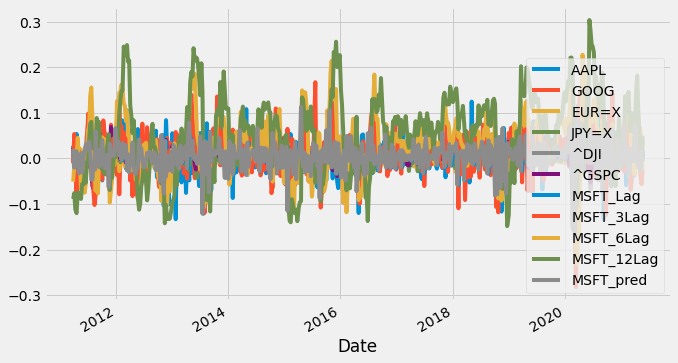

In [74]:
df.plot()

In [38]:
df.describe()

,AAPL,GOOG,EUR=X,JPY=X,^DJI,^GSPC,MSFT_Lag,MSFT_3Lag,MSFT_6Lag,MSFT_12Lag,MSFT_pred
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.004570,0.004178,0.000206,0.000555,0.002092,0.002358,0.004594,0.013673,0.026979,0.052116,0.004405
std,0.039097,0.035399,0.011624,0.011980,0.022911,0.022460,0.031370,0.048992,0.064736,0.085015,0.031361
min,-0.165544,-0.168131,-0.046073,-0.048019,-0.208720,-0.198044,-0.178708,-0.282310,-0.231586,-0.148711,-0.178708
25%,-0.018052,-0.015739,-0.006745,-0.005808,-0.006845,-0.005653,-0.010615,-0.011808,-0.011533,-0.005288,-0.011002
50%,0.005965,0.005353,0.000600,0.000034,0.003286,0.003804,0.006283,0.016785,0.027661,0.058261,0.006207
75%,0.027000,0.024304,0.006986,0.007109,0.013890,0.014025,0.021514,0.043459,0.067756,0.107436,0.021417
max,0.162119,0.167087,0.037628,0.063411,0.115749,0.098984,0.112721,0.145979,0.227306,0.303450,0.112721


In [39]:
X.head()

,AAPL,GOOG,EUR=X,JPY=X,^DJI,^GSPC,MSFT_Lag,MSFT_3Lag,MSFT_6Lag,MSFT_12Lag
Date,,,,,,,,,,
2011-03-30,0.027451,-0.000550,0.004030,0.016788,0.021656,0.023400,0.002737,-0.010874,-0.051371,-0.088507
2011-04-06,-0.030847,-0.013252,-0.007621,0.032813,0.006146,0.005466,0.020866,0.053409,-0.016686,-0.076182
2011-04-13,-0.005666,0.003651,-0.017934,-0.018488,-0.012613,-0.015948,-0.020086,0.003518,-0.017405,-0.111739
2011-04-21,0.053532,-0.096867,-0.004966,-0.016159,0.017817,0.017241,0.003926,0.005107,0.004320,-0.120218
2011-04-29,-0.001627,0.035544,-0.019667,-0.004491,0.024061,0.019423,0.015552,-0.010745,0.044978,-0.075044


In [40]:
Y.head()

Date
2011-03-30    0.020866
2011-04-06   -0.020086
2011-04-13    0.005059
2011-04-21    0.015552
2011-04-29   -0.001931
Name: MSFT_pred, dtype: float64

### Exploratory data analysis
### Data visualization

**Correlation Plot**

<AxesSubplot:title={'center':'Correlation Matrix'}>

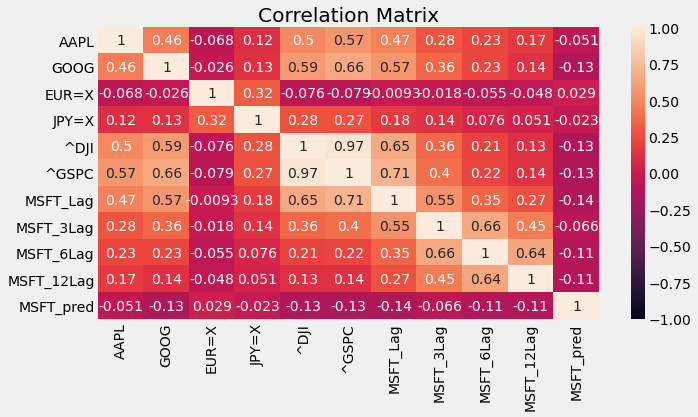

In [41]:
correlation = df.corr()
plt.figure(figsize=(10,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True)

**Scatter Plot**

<Figure size 720x432 with 0 Axes>

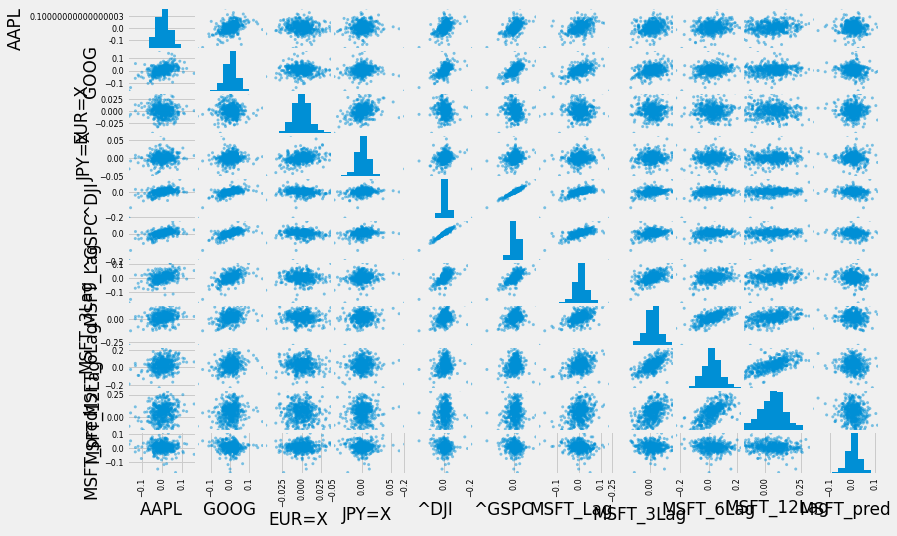

In [42]:
plt.figure(figsize=(10,6))
scatter_matrix(df, figsize=(12, 8))
plt.show()

**Density Plot**

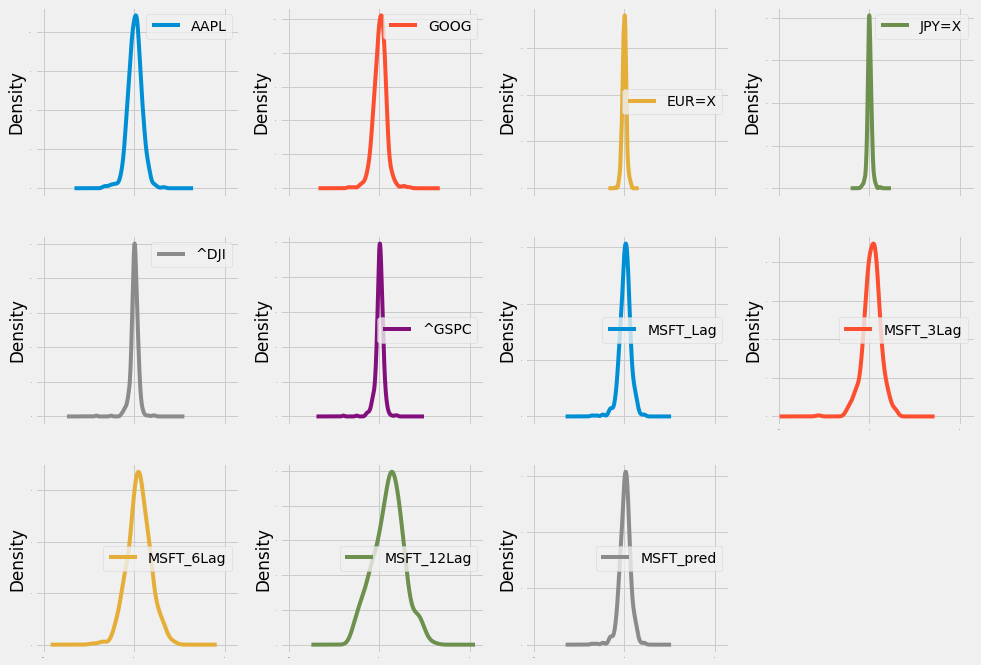

In [43]:
df.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

**Autocorrelation Function and Partial Autocorrelation Function Analysis**

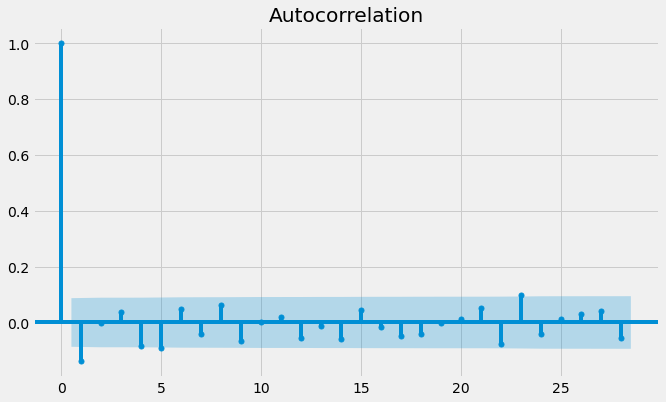

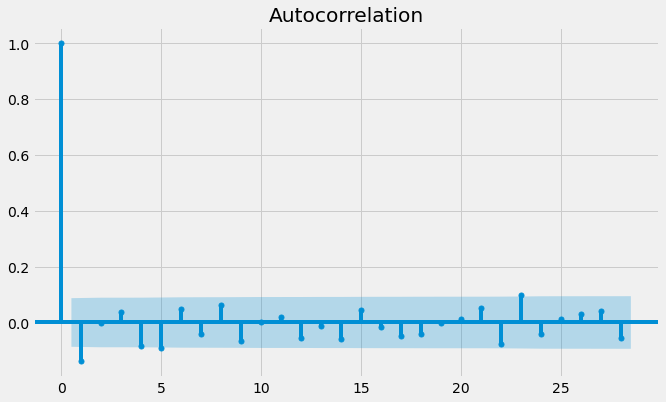

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation of the Closing Prices
plot_acf(df['MSFT_pred'])

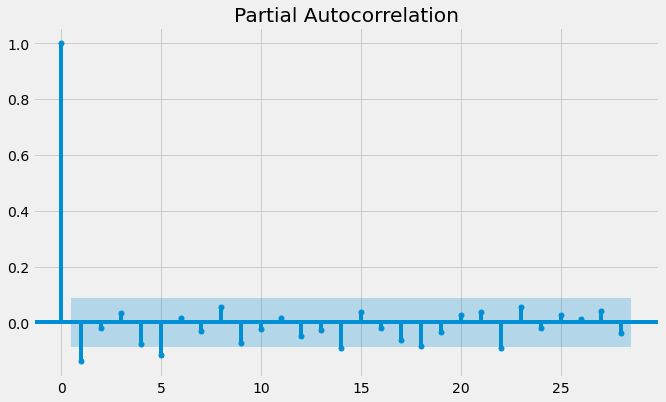

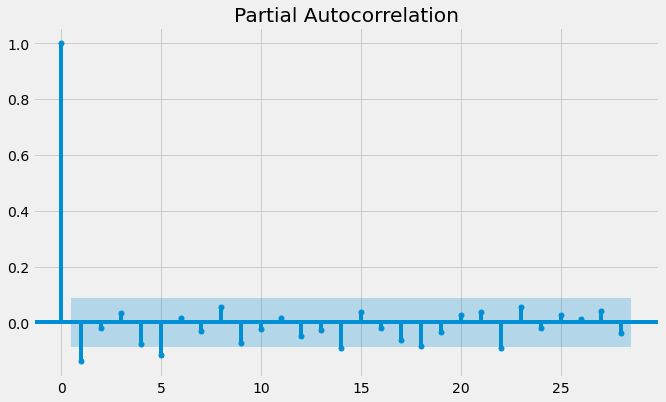

In [45]:
plot_pacf(df['MSFT_pred'])

### Time Series Analysis

Decomposition of the time series of the predicted variable into trend and seasonality components:

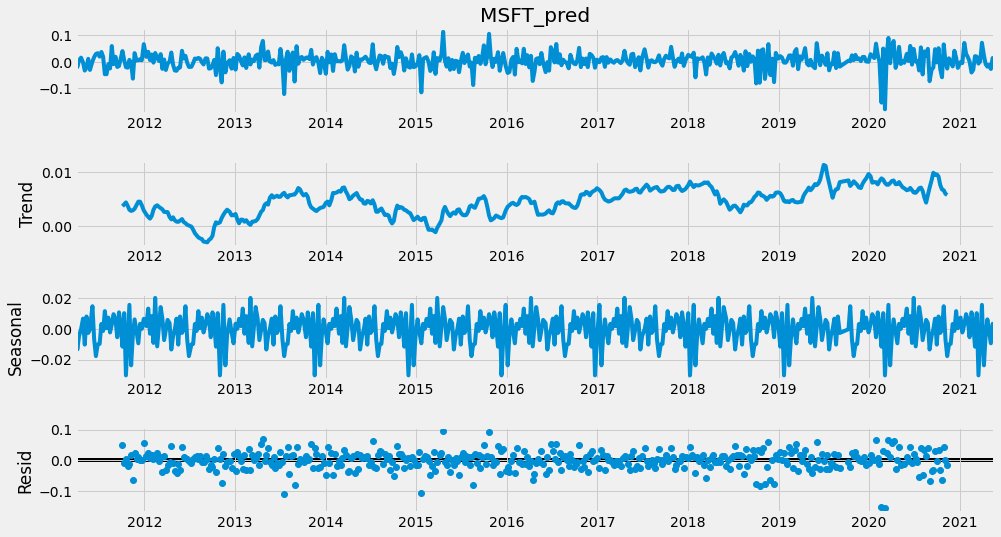

In [46]:
result = sm.tsa.seasonal_decompose(Y, model='additive', freq=52)
figure = result.plot()
figure.set_figheight(8)
figure.set_figwidth(15)
plt.show()

### Evaluate models

In this section, you will need to prepare the training and testing data for the model. The test set is a sample of the data that we use it at the end of our project to confirm the performance of our final model. We will use 70% of the dataset for modeling and use 30% for testing.

In [47]:
split = int(.7 * len(X))
X_train, X_test = X[:split], X[split:len(X)]
Y_train, Y_test = Y[:split], Y[split:len(X)]

## Time Series based models-ARIMA
Let us first prepare the dataset for ARIMA models, by having only the correlated variables as exogenous variables.

### Time Series Model - ARIMA Model

In [48]:
X_train_ARIMA = X_train.loc[:, ['AAPL', 'GOOG', 'EUR=X', 'JPY=X', '^DJI', '^GSPC']]
X_test_ARIMA = X_test.loc[:, ['AAPL', 'GOOG', 'EUR=X', 'JPY=X', '^DJI', '^GSPC']]

In [49]:
X_train_ARIMA.head()

,AAPL,GOOG,EUR=X,JPY=X,^DJI,^GSPC
Date,,,,,,
2011-03-30,0.027451,-0.000550,0.004030,0.016788,0.021656,0.023400
2011-04-06,-0.030847,-0.013252,-0.007621,0.032813,0.006146,0.005466
2011-04-13,-0.005666,0.003651,-0.017934,-0.018488,-0.012613,-0.015948
2011-04-21,0.053532,-0.096867,-0.004966,-0.016159,0.017817,0.017241
2011-04-29,-0.001627,0.035544,-0.019667,-0.004491,0.024061,0.019423


In [50]:
# Import the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# Configure ARIMA model with the order of (p, d, q)=(1,0,1) and use the independent 
# variables as the exogenous variables in the model. The ARIMA model where the exogenous variables are used is known as the ARIMAX model, where 
# 'X' represents exogenous variable.
model_ARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(1,0,1))
model_fit = model_ARIMA.fit()

In [51]:
predictions = model_fit.predict(start = len(X_train_ARIMA)-1, end = len(X)-1, exog=X_test_ARIMA)[1:]
predictions

354   -0.002738
355    0.004360
356    0.007914
357    0.001605
358    0.005276
         ...   
501    0.003920
502   -0.001645
503    0.006040
504    0.006262
505    0.000557
Length: 152, dtype: float64

In [52]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse_Test_ARIMA = mean_squared_error(Y_test, predictions)
rmse_Test_ARIMA = sqrt(mean_squared_error(Y_test, predictions))
print(f"The mean squared error and the root mean squared error of the ARIMA model is {mse_Test_ARIMA} and {rmse_Test_ARIMA}")

The mean squared error and the root mean squared error of the ARIMA model is 0.001393828590086768 and 0.037334013849126484


As we know, mean squared error(MSE) is the average of the squares of the errors that is the average squared difference between the original and predicted values and root mean squared error(RMSE) is the square root of mean square error. The lower value of MSE and RMSE implies higher accuracy of a regression model.

**Lets perform the model tuning of the ARIMA model**

In [53]:
def evaluate_arima_model(arima_order):
    model_arima = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
    model_fit = model_arima.fit()
#     pred = model_fit.predict(len(X_test_ARIMA))
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

**Evaluate combination of p, d and q values for an ARIMA model**

In [54]:
def evaluate_models(p_values, d_values, q_values):
    # float('inf') sets the value as +ve infinity
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                arima_order = (p,d,q)
                try:
                    mse = evaluate_arima_model(arima_order)
                    if mse < best_score:
                        best_score, best_cfg = mse, arima_order
                    print("ARIMA%s MSE=%.7f" % (arima_order, mse))
                except:
                    continue
    print("Best ARIMA%s MSE=%.7f" % (best_cfg, best_score))

**Evaluate parameters**

In [55]:
p_values = [0, 1, 2]
d_values = range(0,2)
q_values = range(0,2)

evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0007910
ARIMA(0, 0, 1) MSE=0.0007888
ARIMA(1, 0, 0) MSE=0.0007890
ARIMA(1, 0, 1) MSE=0.0007884
ARIMA(2, 0, 0) MSE=0.0007875
ARIMA(2, 0, 1) MSE=0.0007851
Best ARIMA(2, 0, 1) MSE=0.0007851


**Finalize the model on the test data and prepare the model**

In [56]:
model_ARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(2,0,1))
model_fit_tuned = model_ARIMA_tuned.fit()

**Estimate accuracy on the validation set**

In [57]:
predicted_tuned = model_fit_tuned.predict(start = len(X_train_ARIMA)-1, end = len(X)-1, exog=X_test_ARIMA)[1:]
mse = mean_squared_error(Y_test, predicted_tuned)
rmse = sqrt(mse)
print(f"The MSE(mean squared root) and RMSE(root mean squared root) are {mse} and {rmse}")

The MSE(mean squared root) and RMSE(root mean squared root) are 0.0013948254655936387 and 0.03734736223073376


In [58]:
Y_test

Date
2018-04-20    0.008595
2018-04-27   -0.006912
2018-05-04    0.026342
2018-05-11   -0.013810
2018-05-18    0.020543
                ...   
2021-04-22   -0.018287
2021-04-29   -0.011071
2021-05-06   -0.027195
2021-05-13    0.014096
2021-05-20    0.011416
Name: MSFT_pred, Length: 152, dtype: float64

**Plotting actual vs. predicted** 

In [59]:
test_tuned_df = Y_test.reset_index()
test_tuned_df['Actual'] = test_tuned_df['MSFT_pred']
test_tuned_df.drop(columns='MSFT_pred', inplace=True)
test_tuned_df.set_index('Date')

,Actual
Date,
2018-04-20,0.008595
2018-04-27,-0.006912
2018-05-04,0.026342
2018-05-11,-0.013810
2018-05-18,0.020543
...,...
2021-04-22,-0.018287
2021-04-29,-0.011071
2021-05-06,-0.027195


In [60]:
test_tuned_df['Predictions'] = predicted_tuned.reset_index().drop(columns='index')
test_tuned_df = test_tuned_df.set_index('Date')
test_tuned_df.head()

,Actual,Predictions
Date,,
2018-04-20,0.008595,-0.004817
2018-04-27,-0.006912,0.004823
2018-05-04,0.026342,0.008495
2018-05-11,-0.013810,0.001668
2018-05-18,0.020543,0.005135


**Save the file for later use in dashboard**

In [63]:
test_tuned_df.to_csv('Export Files/stock_prices_tuned.csv')

<AxesSubplot:title={'center':'Actual vs. Predictions of Microsoft Closing Prices'}, xlabel='Date'>

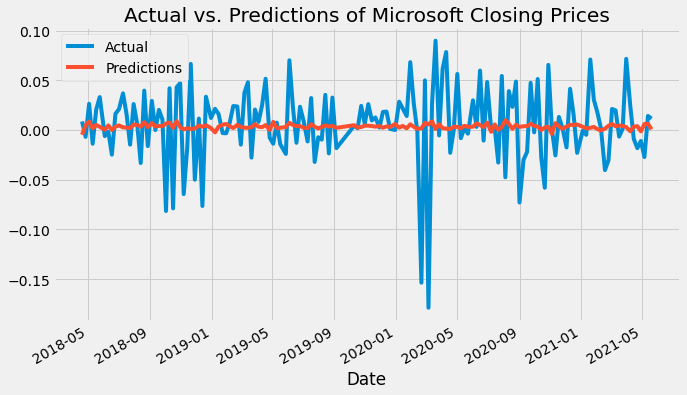

In [64]:
test_tuned_df.plot(title='Actual vs. Predictions of Microsoft Closing Prices')